## EDA: MyAnimeList
###
##### A continuación importamos las librerías que utilizaremos para el análisis.

In [309]:
import pandas as pd
import requests
import numpy as np
import json
from bs4 import BeautifulSoup as bs
import random
import time
import os
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

## Cargar Datos
####
##### Accedemos al archivo CSV que almacena los detalles de los animes en MAL

In [310]:
MAL_df = pd.read_csv('../data/MAL_dataframe.csv')

In [311]:
MAL_df.head()

,id,title,main_picture,alternative_titles,start_date,end_date,synopsis,mean,rank,popularity,num_list_users,num_scoring_users,media_type,status,num_episodes,start_season,studios
0,1,Cowboy Bebop,{'medium': 'https://cdn.myanimelist.net/images...,"{'synonyms': [], 'en': 'Cowboy Bebop', 'ja': '...",1998-04-03,1999-04-24,"Crime is timeless. By the year 2071, humanity ...",8.75,44.0,43,1818165,939118,tv,finished_airing,26,"{'year': 1998, 'season': 'spring'}","[{'id': 14, 'name': 'Sunrise'}]"
1,32772,Puzzle & Dragons Cross,{'medium': 'https://cdn.myanimelist.net/images...,"{'synonyms': ['PazuDora Cross'], 'en': 'Puzzle...",2016-07-04,2018-03-26,"Dorogoza Island is rich in ""Drop Energy"" that ...",6.49,6728.0,6665,8409,2300,tv,finished_airing,89,"{'year': 2016, 'season': 'summer'}","[{'id': 1, 'name': 'Pierrot'}]"
2,5,Cowboy Bebop: Tengoku no Tobira,{'medium': 'https://cdn.myanimelist.net/images...,"{'synonyms': [""Cowboy Bebop: Knockin' on Heave...",2001-09-01,2001-09-01,"Another day, another bounty—such is the life o...",8.38,194.0,610,369342,210529,movie,finished_airing,1,"{'year': 2001, 'season': 'summer'}","[{'id': 4, 'name': 'Bones'}]"
3,6,Trigun,{'medium': 'https://cdn.myanimelist.net/images...,"{'synonyms': [], 'en': 'Trigun', 'ja': 'トライガン'}",1998-04-01,1998-09-30,"Vash the Stampede is the man with a $$60,000,0...",8.22,334.0,248,745104,364884,tv,finished_airing,26,"{'year': 1998, 'season': 'spring'}","[{'id': 11, 'name': 'Madhouse'}]"
4,7,Witch Hunter Robin,{'medium': 'https://cdn.myanimelist.net/images...,"{'synonyms': ['WHR'], 'en': 'Witch Hunter Robi...",2002-07-03,2002-12-25,Robin Sena is a powerful craft user drafted in...,7.24,2942.0,1825,114294,43323,tv,finished_airing,26,"{'year': 2002, 'season': 'summer'}","[{'id': 14, 'name': 'Sunrise'}]"


#####
##### A continuación, llevaremos a cabo la limpieza del DataFrame, centrándonos en uno de los objetivos definidos en la propuesta del proyecto: la identificación de los animes de culto o 'clásicos'. Además, estaremos atentos a posibles análisis adicionales que puedan surgir durante el proceso del EDA y que resulten útiles para el proyecto.
##### 

In [312]:
# Removemos columnas que podrían no ser esenciales al evaluar un anime de culto o que
# podrían estar implicitas en otras columnas clave.
MAL_df_clean = MAL_df.drop(columns=[ 'main_picture', 'alternative_titles', 'media_type', 
       'start_season', 'studios', 'num_scoring_users'])

In [313]:
# Convertimos estas columnas a tipo de dato fecha para darles un mejor uso posteriormente.
MAL_df_clean['start_date'] = pd.to_datetime(MAL_df_clean['start_date'])
MAL_df_clean['end_date'] = pd.to_datetime(MAL_df_clean['end_date'])

In [314]:
MAL_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8978 entries, 0 to 8977
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8978 non-null   int64         
 1   title           8978 non-null   object        
 2   start_date      8976 non-null   datetime64[ns]
 3   end_date        8977 non-null   datetime64[ns]
 4   synopsis        8900 non-null   object        
 5   mean            8908 non-null   float64       
 6   rank            8474 non-null   float64       
 7   popularity      8978 non-null   int64         
 8   num_list_users  8978 non-null   int64         
 9   status          8978 non-null   object        
 10  num_episodes    8978 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)
memory usage: 771.7+ KB


In [315]:
# Verificamos si es que existen duplicados en el DataFrame entero y cuantos en caso de que existan.
# Realizaremos el mismo proceso para los datos nulos.

print(f'Datos duplicados:', MAL_df_clean.duplicated().any())
print(f'N° de datos duplicados:', MAL_df_clean.duplicated().sum())
print(f'Datos nulos: ', MAL_df_clean.isnull().any().any())
print(f'N° de datos nulos: ', MAL_df_clean.isnull().sum().sum())


Datos duplicados: False
N° de datos duplicados: 0
Datos nulos:  True
N° de datos nulos:  655


In [316]:
MAL_df_clean.isnull().sum()

id                  0
title               0
start_date          2
end_date            1
synopsis           78
mean               70
rank              504
popularity          0
num_list_users      0
status              0
num_episodes        0
dtype: int64

In [317]:
filas_nulas_star_date = MAL_df_clean[MAL_df_clean['start_date'].isnull()]
filas_nulas_star_date

,id,title,start_date,end_date,synopsis,mean,rank,popularity,num_list_users,status,num_episodes
2696,33187,Katsudou Shashin,NaT,NaT,A young boy dressed in sailor attire and a bri...,5.48,11422.0,6860,7894,finished_airing,1
8550,30840,Many Things SD Gundam,NaT,2011-07-22,Specials included on SD Gundam Collection Box.,5.00,12520.0,12719,1085,finished_airing,2


In [318]:
MAL_df_clean = MAL_df_clean.drop(2696)

In [319]:
MAL_df_clean['start_date'][8550] = np.datetime64('2011-01-01')
MAL_df_clean.iloc[8550]['start_date']

C:\Users\56936\AppData\Local\Temp\ipykernel_16624\719342837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MAL_df_clean['start_date'][8550] = np.datetime64('2011-01-01')


Timestamp('2015-04-07 00:00:00')

##### Identificamos un anime que carece tanto de fecha de inicio como de fecha de finalización de emisión. Dado que no contamos con información completa sobre su periodo de emisión, hemos decidido no incluir este anime en nuestro análisis. No obstante, hay otro anime que únicamente carece de la fecha de inicio. Optamos por incluir este último en nuestro análisis, ya que pudimos obtener la información faltante de manera verificada a través de este sitio: https://gachax.com/anime/db/many-things-sd-gundam/
####
####
####

In [320]:
filas_nulas_mean = MAL_df_clean[MAL_df_clean['mean'].isnull()]
print(f'N° de animes con valores nulos en la columna de promedio:', len(filas_nulas_mean))

N° de animes con valores nulos en la columna de promedio: 70


In [321]:
filas_nulas_rank = MAL_df_clean[MAL_df_clean['rank'].isnull()]
print(f'N° de animes con valores nulos en la columna de ranking:', len(filas_nulas_rank))

N° de animes con valores nulos en la columna de ranking: 504


In [322]:
nulos_mean_rank = MAL_df_clean[MAL_df_clean[['rank', 'mean']].isnull().all(axis=1)]
print(f'N° de animes con valores nulos en la columna de ranking y promedio:', len(nulos_mean_rank))

N° de animes con valores nulos en la columna de ranking y promedio: 27


In [323]:
MAL_df_clean = MAL_df_clean.dropna(subset=['mean'])
MAL_df_clean = MAL_df_clean.dropna(subset=['rank'])

##### Después de investigar el funcionamiento del sistema de puntuaciones de MAL, que se detalla en el siguiente enlace: https://myanimelist.net/info.php?go=topanime, llegamos a la conclusión de que la presencia de valores nulos en las columnas 'mean' y 'rank' podría tener un impacto en la fiabilidad de la puntuación. Esto podría indicar que la entrada en cuestión no ha recibido suficientes puntuaciones para calcular una puntuación ponderada confiable, posiblemente debido a que es menos conocida o reciente. Dado que nuestro análisis se centra en evaluar la calidad general de los animes, consideramos útil excluir las entradas con valores nulos para obtener una visión más precisa  
#
#
#

In [324]:
filas_nulas_synopsis = MAL_df_clean[MAL_df_clean['synopsis'].isnull()]
filas_nulas_synopsis.head()

,id,title,start_date,end_date,synopsis,mean,rank,popularity,num_list_users,status,num_episodes
523,33308,Tantei Opera Milky Holmes: Fun Fun Party Night...,2016-12-31,2016-12-31,NaN,6.67,5689.0,10355,2410,finished_airing,1
1177,34032,King of Prism: Pride the Hero,2017-06-10,2017-06-10,NaN,6.87,4715.0,8505,4562,finished_airing,1
1661,34552,Dream Festival! R,2017-08-23,2017-11-08,NaN,6.83,4901.0,8048,5300,finished_airing,12
2024,35081,The iDOLM@STER Million Live! 4-shuunen Kinen PV,2017-03-12,2017-03-12,NaN,6.52,6552.0,10112,2600,finished_airing,1
2026,33035,"Yuyushiki: Komarasetari, Komarasaretari",2017-02-22,2017-02-22,NaN,7.31,2589.0,5647,12661,finished_airing,1


In [325]:
print(f'N° de animes sin sinopsis:', len(filas_nulas_synopsis))

N° de animes sin sinopsis: 57


In [326]:
print(f'Promedio máximo del conjunto de animes sin sinopsis', filas_nulas_synopsis['mean'].max())

Promedio máximo del conjunto de animes sin sinopsis 7.78


##### Dado que hay animes sin sinopsis, se podría contemplar un enfoque diferenciado. Por un lado, podríamos incluir todos los animes en el análisis, mientras que, por otro lado, podríamos centrarnos únicamente en aquellos que cuentan con sinopsis. Sin embargo, dado que hay 78 animes sin sinopsis y en análisis posteriores utilizaremos un umbral de calificación superior a 8, excluyendo así a estos animes, hemos decidido eliminarlos del conjunto de datos.
#
#
#

#
## La Evolución Temporal de Calificaciones y Popularidad de los animes en MAL.

In [327]:
'''
Definimos umbral del promedio de calificaciones y en base a este umbral definiremos el de popularidad.
Esto debido a que la variable de popularidad no suele ser un factor determinante al momento de definir
sin un anime es de culto o no.
'''

umbral_calificacion_alta = 8.0
umbral_popularidad_alta = 0

while True:
    animes_alta_calificacion = MAL_df_clean[MAL_df_clean['mean'] >= umbral_calificacion_alta]
    animes_alta_popularidad = MAL_df_clean[MAL_df_clean['popularity'] <= umbral_popularidad_alta]
    if len(animes_alta_calificacion) == len(animes_alta_popularidad):
        umbral_popularidad_alta = umbral_popularidad_alta
        break
    else:
        umbral_popularidad_alta += 1

print(f'N° de animes de cada conjunto:', len(animes_alta_calificacion))

N° de animes de cada conjunto: 597


In [328]:
# Unimos los conjuntos de animes filtrados posteriormente, para obtener entre ambos, animes 
# que se destaquen en MAL y posiblemente potenciales candidatos a ser animes de culto.
animes_destacados = pd.merge(animes_alta_calificacion, animes_alta_popularidad, how='inner')
print(f'N° de animes destacados: ', len(animes_destacados))

N° de animes destacados:  262


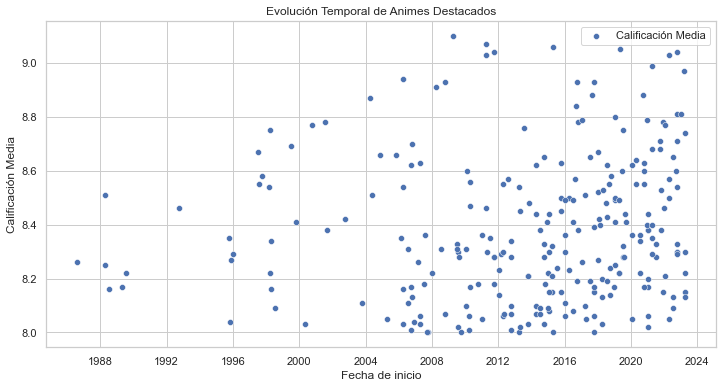

In [329]:
# Gráfico para evaluar la evolución temporal
plt.figure(figsize=(12, 6))
sns.scatterplot(x='start_date', y='mean', data=animes_destacados, marker='o', label='Calificación Media')
plt.title('Evolución Temporal de Animes Destacados')
plt.xlabel('Fecha de inicio')
plt.ylabel('Calificación Media')
plt.legend()
plt.show()

##### Al analizar el scatterplot, notamos que una considerable cantidad de los animes destacados tienen fechas de inicio cercanas a la actualidad. Sin embargo, es crucial destacar que la condición de 'anime de culto' está estrechamente vinculada con la longevidad, así como el impacto que el anime pueda tener en la sociedad y la conexión que logre establecer con la audiencia. Por lo tanto, no podemos basarnos exclusivamente en aquellos con una calificación promedio más alta o con fechas de inicio antiguas, ya que ambos aspectos deben converger para que un anime sea considerado de culto. Por otro lado, la gráfica proporciona una visión general de la distribución temporal de estos animes destacados, lo que nos ayuda a identificar posibles candidatos.
#
#
# 

#
## Exploración de Animes a través de las Listas de Usuarios

In [330]:
animes_destacados_por_listas = MAL_df_clean.sort_values(by='num_list_users', ascending=False)

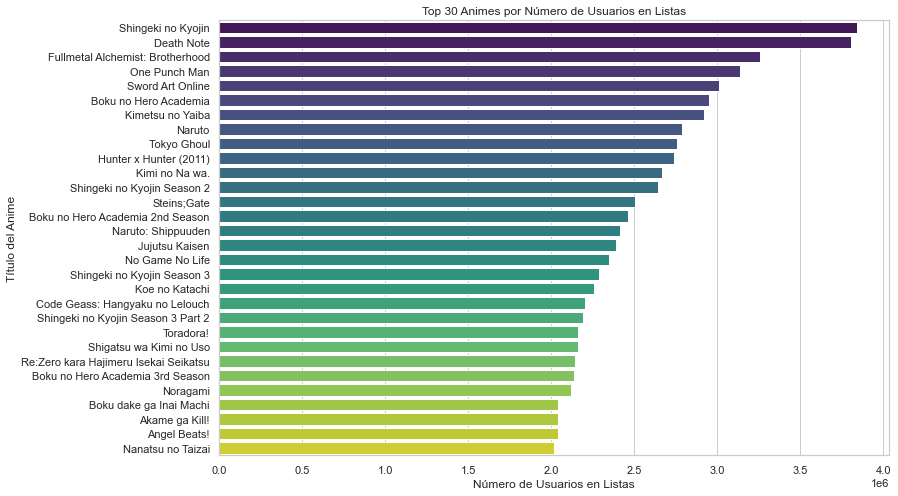

In [331]:
sns.set(style="whitegrid")

# Creamos el gráfico de barras
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='num_list_users', y='title', data=animes_destacados_por_listas.head(30), palette='viridis')
plt.title('Top 30 Animes por Número de Usuarios en Listas')
plt.xlabel('Número de Usuarios en Listas')
plt.ylabel('Título del Anime')
plt.show()

In [332]:
animes_destacados_final = pd.merge(animes_destacados_por_listas.head(100), animes_destacados, on=
                                   ['id', 'title', 'start_date', 'end_date', 'synopsis', 'mean', 'rank',
       'popularity', 'num_list_users', 'status', 'num_episodes'], how='inner')
animes_destacados_final.head()

,id,title,start_date,end_date,synopsis,mean,rank,popularity,num_list_users,status,num_episodes
0,16498,Shingeki no Kyojin,2013-04-07,2013-09-29,"Centuries ago, mankind was slaughtered to near...",8.54,110.0,1,3841111,finished_airing,25
1,1535,Death Note,2006-10-04,2007-06-27,"Brutal murders, petty thefts, and senseless vi...",8.62,83.0,2,3804024,finished_airing,37
2,5114,Fullmetal Alchemist: Brotherhood,2009-04-05,2010-07-04,After a horrific alchemy experiment goes wrong...,9.10,1.0,3,3255493,finished_airing,64
3,30276,One Punch Man,2015-10-05,2015-12-21,The seemingly unimpressive Saitama has a rathe...,8.50,131.0,4,3134268,finished_airing,12
4,38000,Kimetsu no Yaiba,2019-04-06,2019-09-28,"Ever since the death of his father, the burden...",8.49,133.0,7,2917758,finished_airing,26


In [333]:
# # Comprobamos si existe animes que siguen siendo trasmitidos
if any(status != 'finished_airing' for status in animes_destacados_final['status']):
    print("Hay animes que siguen siendo transmitidos.")
else:
    print("No existen animes que sigan en transmisión.")


No existen animes que sigan en transmisión.


##### A partir de lo anterior, se puede inferir que el estado de 'status' desempeñaría un papel crucial al determinar qué animes podrían considerarse de culto.
#
#

#
## Exploración de Animes a través de su N° de Episodios

In [334]:
print("Descripción estadística del N° de episodios de cada anime:\n")
print(animes_destacados_final['num_episodes'].describe())

Descripción estadística del N° de episodios de cada anime:

count     68.000000
mean      29.602941
std       63.522975
min        1.000000
25%       12.000000
50%       19.000000
75%       25.000000
max      500.000000
Name: num_episodes, dtype: float64


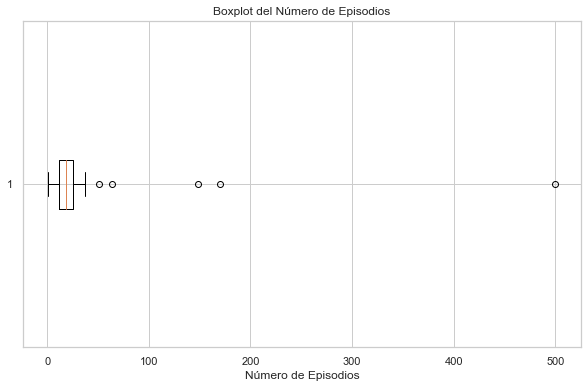

In [335]:
plt.figure(figsize=(10, 6))
plt.boxplot(animes_destacados_final['num_episodes'], vert=False)
plt.title('Boxplot del Número de Episodios')
plt.xlabel('Número de Episodios')
plt.show()


In [340]:
animes_destacados_final.sort_values(by='num_episodes', ascending=False).head(3)

,id,title,start_date,end_date,synopsis,mean,rank,popularity,num_list_users,status,num_episodes
10,1735,Naruto: Shippuuden,2007-02-15,2017-03-23,It has been two and a half years since Naruto ...,8.26,292.0,15,2415660,finished_airing,500
41,34572,Black Clover,2017-10-03,2021-03-30,Asta and Yuno were abandoned at the same churc...,8.15,421.0,60,1608533,finished_airing,170
5,11061,Hunter x Hunter (2011),2011-10-02,2014-09-24,Hunters devote themselves to accomplishing haz...,9.04,8.0,10,2740243,finished_airing,148


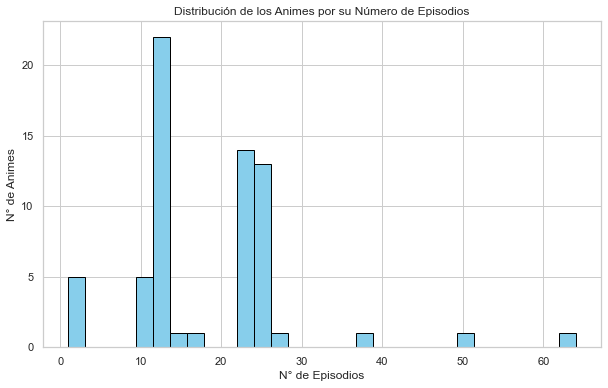

In [350]:
plt.figure(figsize=(10, 6))
plt.hist(animes_destacados_final['num_episodes'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de los Animes por su Número de Episodios')
plt.xlabel('N° de Episodios')
plt.ylabel('N° de Animes')
plt.show()

In [354]:
animes_destacados_final.sort_values(by='num_episodes').head(5)

,id,title,start_date,end_date,synopsis,mean,rank,popularity,num_list_users,status,num_episodes
6,32281,Kimi no Na wa.,2016-08-26,2016-08-26,"Mitsuha Miyamizu, a high school girl, yearns t...",8.84,27.0,11,2667200,finished_airing,1
48,40456,Kimetsu no Yaiba Movie: Mugen Ressha-hen,2020-10-16,2020-10-16,After a string of mysterious disappearances be...,8.60,89.0,76,1472056,finished_airing,1
14,28851,Koe no Katachi,2016-09-17,2016-09-17,"As a wild youth, elementary school student Sho...",8.93,19.0,20,2257629,finished_airing,1
31,199,Sen to Chihiro no Kamikakushi,2001-07-20,2001-07-20,"Stubborn, spoiled, and naïve, 10-year-old Chih...",8.78,38.0,44,1806669,finished_airing,1
66,431,Howl no Ugoku Shiro,2004-11-20,2004-11-20,"That jumbled piece of architecture, that cacop...",8.66,69.0,99,1294537,finished_airing,1


In [355]:
animes_a_eliminar = [1735, 34572, 11061, 32281, 40456, 28851, 199, 431]
animes_destacados_final = animes_destacados_final.loc[~animes_destacados_final['id'].isin(animes_a_eliminar)]

##### Identificamos la presencia de ciertos valores atípicos en la distribución, y es necesario excluirlo del análisis para evitar posibles distorsiones en los resultados.
#
#

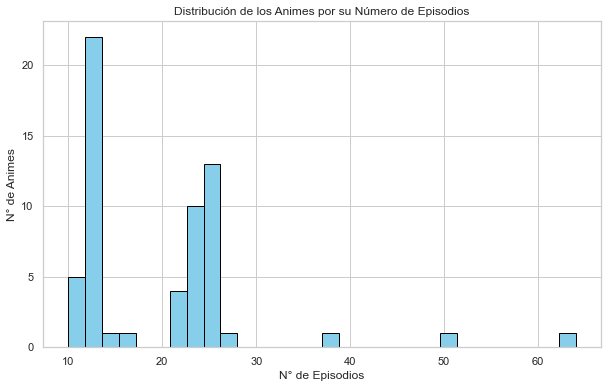

In [356]:
plt.figure(figsize=(10, 6))
plt.hist(animes_destacados_final['num_episodes'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de los Animes por su Número de Episodios')
plt.xlabel('N° de Episodios')
plt.ylabel('N° de Animes')
plt.show()

In [357]:
print("Nueva descripción estadística del N° de episodios de cada anime:\n")
print(animes_destacados_final['num_episodes'].describe())

Nueva descripción estadística del N° de episodios de cada anime:

count    60.000000
mean     19.833333
std       9.686907
min      10.000000
25%      12.000000
50%      22.000000
75%      25.000000
max      64.000000
Name: num_episodes, dtype: float64


In [361]:
# Posibles candidatos a ser animes de culto
animes_destacados_final.sort_values(by='end_date').head(10)

,id,title,start_date,end_date,synopsis,mean,rank,popularity,num_list_users,status,num_episodes
32,30,Neon Genesis Evangelion,1995-10-04,1996-03-27,Fifteen years after a cataclysmic event known ...,8.35,208.0,45,1769372,finished_airing,26
30,1,Cowboy Bebop,1998-04-03,1999-04-24,"Crime is timeless. By the year 2071, humanity ...",8.75,44.0,43,1818165,finished_airing,26
50,121,Fullmetal Alchemist,2003-10-04,2004-10-02,"Edward Elric, a young, brilliant alchemist, ha...",8.11,460.0,78,1448079,finished_airing,51
1,1535,Death Note,2006-10-04,2007-06-27,"Brutal murders, petty thefts, and senseless vi...",8.62,83.0,2,3804024,finished_airing,37
15,1575,Code Geass: Hangyaku no Lelouch,2006-10-06,2007-07-29,"In the year 2010, the Holy Empire of Britannia...",8.70,56.0,21,2200278,finished_airing,25
44,2001,Tengen Toppa Gurren Lagann,2007-04-01,2007-09-30,Simon and Kamina were born and raised in a dee...,8.63,78.0,65,1578941,finished_airing,27
57,2167,Clannad,2007-10-05,2008-03-28,Tomoya Okazaki is a delinquent who finds life ...,8.00,614.0,87,1393009,finished_airing,23
33,2904,Code Geass: Hangyaku no Lelouch R2,2008-04-06,2008-09-28,"One year has passed since the Black Rebellion,...",8.91,20.0,47,1739629,finished_airing,25
17,4224,Toradora!,2008-10-02,2009-03-26,Ryuuji Takasu is a gentle high school student ...,8.07,519.0,23,2161851,finished_airing,25
60,5081,Bakemonogatari,2009-07-03,2010-06-25,"Koyomi Araragi, a third-year high school stude...",8.33,225.0,90,1376954,finished_airing,15


#
### En conclusión, obtenemos una selección de posibles candidatos a ser considerados animes de culto. No obstante, es fundamental reconocer que la noción de "anime de culto" puede variar según las preferencias y percepciones individuales. Sin embargo, esta condición puede ser extrapolada a factores como el impacto, la longevidad y la conexión con la audiencia. Este análisis intenta proporcionar una visión integral que pueda contribuir a la comprensión de las características que distinguen a los animes de culto en la comunidad.